In [1]:
# =========================================================
# Nested NPIV demo: sequential (AGMM) vs simultaneous (AGMM2L2)
# =========================================================

import os
import sys
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt

# ---------- Keep BLAS/OpenMP threads in check (faster + stable with PyTorch/Joblib) ----------
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# ---------- Reproducibility ----------
def seed_everything(seed: int = 123) -> None:
    import random, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(123)

# Add path to data-generating processes (adjust if needed)
sys.path.append(str(Path.cwd() / "../../simulations"))
import dgps_nested as dgps

# PyTorch + estimators
import torch
import torch.nn as nn
from nnpiv.neuralnet import AGMM, AGMM2L2

# ---------- Plotting defaults ----------
plt.style.use("seaborn-v0_8-white")
plt.rcParams["figure.dpi"] = 120

# ---------- Global model hyperparams ----------
p = 0.10         # dropout prob
n_hidden = 100   # hidden layer width
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
try:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)
except Exception:
    pass

In [2]:
# =========================================================
# Helper builders
# =========================================================
def get_learner(n_t: int) -> nn.Module:
    """Small MLP for the learner network."""
    return nn.Sequential(
        nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
        nn.Dropout(p=p), nn.Linear(n_hidden, 1)
    )

def get_adversary(n_z: int) -> nn.Module:
    """Small MLP for the adversary network."""
    return nn.Sequential(
        nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
        nn.Dropout(p=p), nn.Linear(n_hidden, 1)
    )

def make_test_grid(X: np.ndarray, var_idx: int = 0, n: int = 1000,
                   q_low: float = 5.0, q_high: float = 95.0) -> np.ndarray:
    """
    Build a grid by sweeping one column between quantiles, fixing others at their median.
    """
    grid = np.tile(np.median(X, axis=0, keepdims=True), (n, 1))
    grid[:, var_idx] = np.linspace(np.percentile(X[:, var_idx], q_low),
                                   np.percentile(X[:, var_idx], q_high), n)
    return grid[np.argsort(grid[:, var_idx])]


# =========================================================
# Data generation 
# =========================================================
# Function dictionary (for reference):
# {'abs': 0, '2dpoly': 1, 'sigmoid': 2, 'sin': 3, 'frequent_sin': 4, 'abs_sqrt': 5,
#  'step': 6, '3dpoly': 7, 'linear': 8, 'rand_pw': 9, 'abspos': 10, 'sqrpos': 11,
#  'band': 12, 'invband': 13, 'steplinear': 14, 'pwlinear': 15, 'exponential': 16}

fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)

# A, D are first stage (endog + instruments); B, C are second stage; Y is outcome
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)

# Build test grids for plotting
B_test = make_test_grid(B, var_idx=0, n=1000, q_low=5, q_high=95)
A_test = make_test_grid(A, var_idx=0, n=1000, q_low=5, q_high=95)

true_fn_B = tau_fn(B_test)         # true structural function in terms of B
true_fn_A = A_test[:, 0]           # for first stage visualization (if desired)


# =========================================================
# Estimation routines
# =========================================================
def nested_npivfit_sequential(
    A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, Y: np.ndarray,
    B_test: np.ndarray, A_test: np.ndarray,
    model1: AGMM, model2: AGMM,
    fitargs: dict | None = None
):
    """
    Two-step nested NPIV (sequential):
      1) Fit bridge for g: A <- D  (predict g(A))
      2) Fit bridge for h: B <- C  (target = g(A))
    Returns predictions on B_test and A_test.
    """
    fitargs = fitargs or {}
    # To torch on DEVICE once
    A_t = torch.as_tensor(A, dtype=torch.float32, device=DEVICE)
    B_t = torch.as_tensor(B, dtype=torch.float32, device=DEVICE)
    C_t = torch.as_tensor(C, dtype=torch.float32, device=DEVICE)
    D_t = torch.as_tensor(D, dtype=torch.float32, device=DEVICE)
    Y_t = torch.as_tensor(Y, dtype=torch.float32, device=DEVICE)
    Btest_t = torch.as_tensor(B_test, dtype=torch.float32, device=DEVICE)
    Atest_t = torch.as_tensor(A_test, dtype=torch.float32, device=DEVICE)

    # First stage: g(A) using instruments D
    model1.fit(D_t, A_t, Y_t, device=DEVICE, **fitargs)
    # predict returns numpy on CPU; convert back to Tensor on DEVICE for stage 2
    g_hat_np = model1.predict(A_t)
    g_hat_t = torch.as_tensor(g_hat_np, dtype=torch.float32, device=DEVICE)

    # Second stage: h(B) using instruments C, target = g_hat(A)
    model2.fit(C_t, B_t, g_hat_t, device=DEVICE, **fitargs)
    h_hat_Btest = model2.predict(Btest_t)                       # numpy
    g_hat_Atest = model1.predict(Atest_t)                       # numpy

    # Return 1D arrays for quick plotting
    return h_hat_Btest.ravel(), g_hat_Atest.ravel()


def nested_npivfit_simultaneous(
    A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, Y: np.ndarray,
    B_test: np.ndarray, A_test: np.ndarray,
    model: AGMM2L2,
    n_epochs: int = 350
):
    """
    Joint (simultaneous) nested NPIV training via AGMM2L2.
    Returns predictions h(B_test), g(A_test) as 1D arrays.
    """
    # To torch on DEVICE once
    A_t = torch.as_tensor(A, dtype=torch.float32, device=DEVICE)
    B_t = torch.as_tensor(B, dtype=torch.float32, device=DEVICE)
    C_t = torch.as_tensor(C, dtype=torch.float32, device=DEVICE)
    D_t = torch.as_tensor(D, dtype=torch.float32, device=DEVICE)
    Y_t = torch.as_tensor(Y, dtype=torch.float32, device=DEVICE)
    Btest_t = torch.as_tensor(B_test, dtype=torch.float32, device=DEVICE)
    Atest_t = torch.as_tensor(A_test, dtype=torch.float32, device=DEVICE)

    model.fit(A_t, B_t, C_t, D_t, Y_t, n_epochs=n_epochs, device=DEVICE)
    h_hat_Btest, g_hat_Atest = model.predict(Btest_t, Atest_t)  # numpy outputs
    return h_hat_Btest.ravel(), g_hat_Atest.ravel()

In [3]:
# =========================================================
# Build models and run
# =========================================================
# Sequential estimator: two AGMMs
agmm_1 = AGMM(get_learner(A.shape[1]), get_adversary(D.shape[1]))  # stage-1 (A <- D)
agmm_2 = AGMM(get_learner(B.shape[1]), get_adversary(C.shape[1]))  # stage-2 (B <- C)
fitargs = dict(n_epochs=150, bs=256, learner_lr=1e-4, adversary_lr=1e-4,
               learner_l2=1e-3, adversary_l2=1e-4)

agmm_pred_B, agmm_pred_gA = nested_npivfit_sequential(
    A, B, C, D, Y, B_test, A_test, model1=agmm_1, model2=agmm_2, fitargs=fitargs
)

# Simultaneous estimator: AGMM2L2 (joint) 
agmm2l2_model = AGMM2L2(
    learnerh=get_learner(B.shape[1]),
    learnerg=get_learner(A.shape[1]),
    adversary1=get_adversary(D.shape[1]),
    adversary2=get_adversary(C.shape[1]),
)
agmm2l2_pred_B, agmm2l2_pred_gA = nested_npivfit_simultaneous(
    A, B, C, D, Y, B_test, A_test, agmm2l2_model, n_epochs=350
)

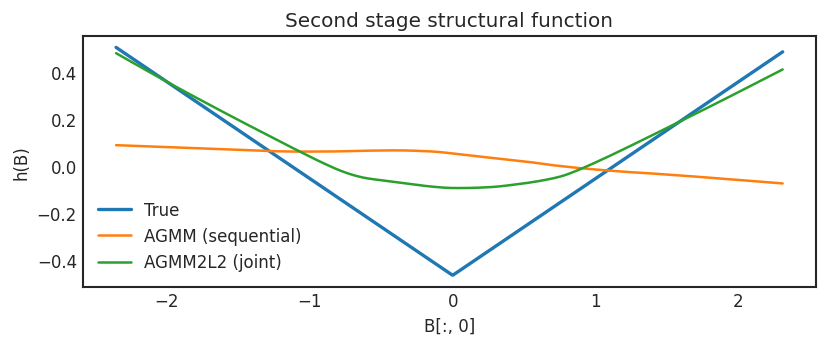

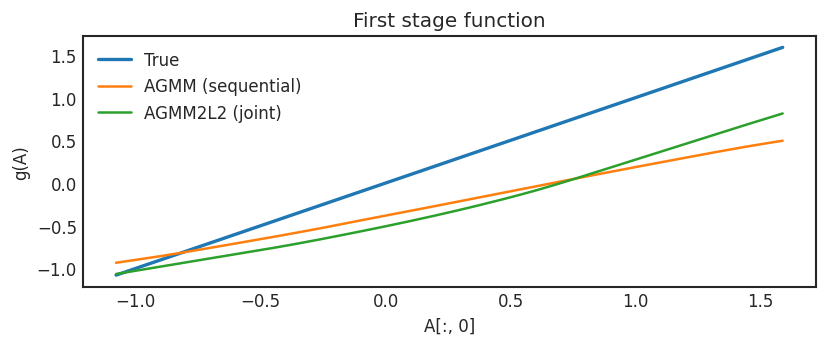

In [4]:
# =========================================================
# Plots
# =========================================================
# h(B): structural function vs estimates (varying B[:, 0])
plt.figure(figsize=(7, 3))
plt.plot(B_test[:, 0], true_fn_B, label="True", linewidth=2)
plt.plot(B_test[:, 0], agmm_pred_B, label="AGMM (sequential)")
plt.plot(B_test[:, 0], agmm2l2_pred_B, label="AGMM2L2 (joint)")
plt.xlabel("B[:, 0]")
plt.ylabel("h(B)")
plt.legend(frameon=False)
plt.title("Second stage structural function")
plt.tight_layout()
plt.show()

# g(A): first-stage function vs estimates (varying A[:, 0])
plt.figure(figsize=(7, 3))
plt.plot(A_test[:, 0], true_fn_A, label="True", linewidth=2)
plt.plot(A_test[:, 0], agmm_pred_gA, label="AGMM (sequential)")
plt.plot(A_test[:, 0], agmm2l2_pred_gA, label="AGMM2L2 (joint)")
plt.xlabel("A[:, 0]")
plt.ylabel("g(A)")
plt.legend(frameon=False)
plt.title("First stage function")
plt.tight_layout()
plt.show()